## ===== Part 1: Analyze stock trends =====

Change parameter below

In [1]:
TICKER = "MSFT"
PERIOD = "6mo"  # one of 3mo, 6mo, 1y, 2y

In [2]:
import yfinance as yf

ticker = yf.Ticker(TICKER)
symbol = ticker.info["symbol"]
name = ticker.info["displayName"]
df = ticker.history(period=PERIOD)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-10 00:00:00-05:00,423.003698,423.083378,413.430488,417.345459,20201100,0.0,0.0
2025-01-13 00:00:00-05:00,413.649650,416.897174,410.710966,415.592194,17604800,0.0,0.0
2025-01-14 00:00:00-05:00,416.209822,418.132423,409.146979,414.078033,16935900,0.0,0.0
2025-01-15 00:00:00-05:00,417.524783,426.510226,416.668060,424.677277,19637800,0.0,0.0
2025-01-16 00:00:00-05:00,427.058103,427.845056,422.764613,422.953857,15300000,0.0,0.0


In [3]:
"""Partition stock trends into major changes"""

import numpy as np

from stock_gone_wrong.event.signal import (find_largest_changes,
                                           find_stock_peaks, remove_saddle)

data = df["Close"].to_numpy()
maxima = find_stock_peaks(data, window=2)
minima = find_stock_peaks(-data, window=2)

extrema = np.unique(np.concat(([0, data.size - 1], minima, maxima)))
trends = remove_saddle(data, extrema)
changes = find_largest_changes(data, trends, 5)

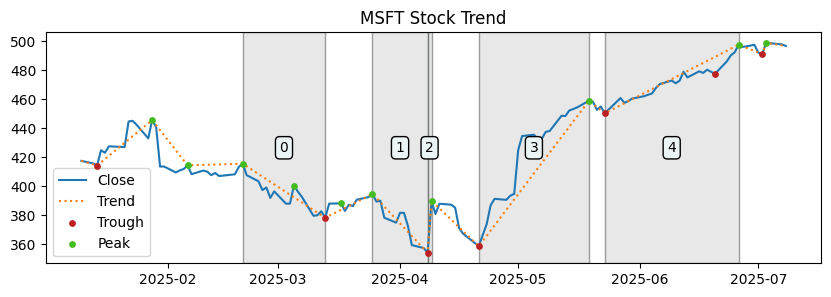

In [4]:
"""Visualize the partition results, and highlight major upturns/downturns"""

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 3))
mid_y = (data.min() + data.max()) / 2
bbox = {
    "facecolor": "#ECF5F5",
    "edgecolor": "black",
    "boxstyle": "round,pad=0.3",
}
for i, (x, y) in enumerate(changes):
    plt.axvspan(
        df.index[x],
        df.index[y],
        facecolor="lightgray",
        edgecolor="#434747",
        alpha=0.5,
        zorder=-10,
    )
    mid_x = df.index[x] + (df.index[y] - df.index[x]) / 2
    plt.text(mid_x, mid_y, f"{i}", ha="center", va="center", zorder=20, bbox=bbox)
plt.plot(df["Close"], label="Close")
plt.plot(df["Close"].iloc[trends], linestyle=":", label="Trend")
plt.scatter(
    df.index[minima], data[minima], s=15, color="#BC2020", zorder=10, label="Trough"
)
plt.scatter(
    df.index[maxima], data[maxima], s=15, color="#42BC20", zorder=10, label="Peak"
)
plt.title(f"{symbol} Stock Trend")
plt.legend()
plt.show()

## ===== Part 2: Explain stock event =====

Change parameter below

In [5]:
CHANGE = 3  # refer to the graph
MODEL = "granite3.2:8b"  # one of installed ollama models, for question answering
EMBEDDING = "llama3.2:1b"  # one of installed ollama models, for embedding

In [6]:
from langchain_ollama import ChatOllama, OllamaEmbeddings

try:
    chat = ChatOllama(model=MODEL)
    embeddings = OllamaEmbeddings(model=EMBEDDING)
    response = chat.stream("Who was the first man on the moon?")
    for r in response:
        break
    embeddings.embed_query("Stock price analysis")
    print("Using ollama models successfully")
except:
    print(
        "Error in using ollama model. Please make sure it is opened and the model is available"
    )

Using ollama models successfully


In [7]:
"""Search related news on Google"""

from typing import cast

from pandas import Timestamp

from stock_gone_wrong.event.search_news import search_news

change = changes[CHANGE]
start_date = cast(Timestamp, df.index[change[0]])
end_date = cast(Timestamp, df.index[change[1]])
search_results = search_news(f"{name}({symbol}) stock price", start_date, end_date)
print(f"Found {len(search_results)} news")

Found 10 news


In [8]:
from stock_gone_wrong.event.agent import load_links

links: list[str] = [r.url for r in search_results]
vector_store = load_links(links, embeddings)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Create vector store: 100%|██████████| 73/73 [01:03<00:00,  1.15it/s]


In [9]:
from stock_gone_wrong.event.agent import model_qa

verb = "rise" if data[change[0]] < data[change[1]] else "drop"
query = f"Why does the stock price of {name} ({symbol}) {verb}?"
response, similar_docs = model_qa(chat, query, vector_store)

start_str = start_date.strftime("%Y-%m-%d")
end_str = end_date.strftime("%Y-%m-%d")
print(
    f"Event: {symbol} {verb}s from {data[change[0]]:.2f} in {start_str} to {data[change[1]]:.2f} in {end_str}"
)
print("Query:", query)
source_urls = list(set([d.metadata["source"] for d in similar_docs]))
print("Sources:", source_urls)
print("Response:", end="")
for r in response:
    print(r.content, end="")

Event: MSFT rises from 358.46 in 2025-04-21 to 458.87 in 2025-05-19
Query: Why does the stock price of Microsoft (MSFT) rise?
Sources: ['https://www.investopedia.com/why-microsoft-stock-had-one-of-its-best-post-earnings-days-in-a-decade-11726613', 'https://www.tastylive.com/news-insights/microsoft-msft-earnings-preview-ai-growth-market-uncertainty', 'https://www.nasdaq.com/articles/why-microsoft-msft-top-stock-long-term-2']
Response:
Microsoft's (MSFT) stock price rises due to strong financial performance and positive market reception of its AI and cloud platform, Azure. Its Q4 2021 earnings beat Wall Street estimates, with cloud-computing revenue surging to $27 billion, driven by faster-than-expected growth in Azure. Additionally, the company's CFO noted that AI demand continues to outstrip supply, which boosted investor confidence. The low implied volatility for Microsoft earnings and its strong position in the PC software market also contribute to its stock price increase.